In [16]:
import tarfile
import pandas as pd
import os

In [7]:
def count_png_files_in_tar(tar_path):
    with tarfile.open(tar_path, 'r') as tar:
        png_files = [member for member in tar.getmembers() if member.isfile() and member.name.endswith('.png')]
        return len(png_files)

count_png_files_in_tar("C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 24-25/Intro to Focus Areas/Data Science/data/BreaKHis_v1.tar.gz")

7909

Import Data to DataFrame, include Benign/Malignant with ID, Choose a Magnification

In [33]:
def extract_image_labels(tar_path):
    image_ids = []
    labels = []

    with tarfile.open(tar_path, 'r') as tar:
        for member in tar.getmembers():
            file_name = os.path.basename(member.name)
            # Check if the member is a file and matches the format for a PNG with 100x magnification
            if file_name.endswith('.png'):
                # Extract parts of the filename
                parts = file_name.split('-')

                label = parts[0].split('_')[1]  # 'M' or 'B' indicating malignancy
                magnification = parts[3]  # Magnification levelS
                image_id = str(parts[1]) + '-' + str(parts[2]) + '-' + str(parts[3]) + '-' + str(parts[4]) # Unique image ID
                    
                # Filter for images with 100x magnification
                if magnification == '100':
                    labels.append(label)
                    image_ids.append(image_id)
    
    # Create a DataFrame with the extracted data
    df = pd.DataFrame({
        'Image_ID': image_ids,
        'Label': labels
    })
    
    return df

In [34]:
image_labels_df = extract_image_labels("C:/Users/igali/OneDrive/Desktop/Bioinfo/WiSe 24-25/Intro to Focus Areas/Data Science/data/BreaKHis_v1.tar.gz")


In [35]:
image_labels_df.head()

,Image_ID,Label
0,14-20629-100-027.png,M
1,14-15275-100-008.png,B
2,14-5694-100-013.png,M
3,14-22549G-100-026.png,B
4,14-21998AB-100-054.png,B


Split Data

In [32]:
from sklearn.model_selection import train_test_split

In [37]:
labels = image_labels_df['Label']


X_train, X_temp = train_test_split(image_labels_df, test_size=0.3, stratify=labels, random_state = 42)

label_test_val = X_temp['Label']

X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)

The shape of train data (1456, 2)
The shape of test data (312, 2)
The shape of validation data (313, 2)


Visualize Distribution of Train, Test, Validation Data

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

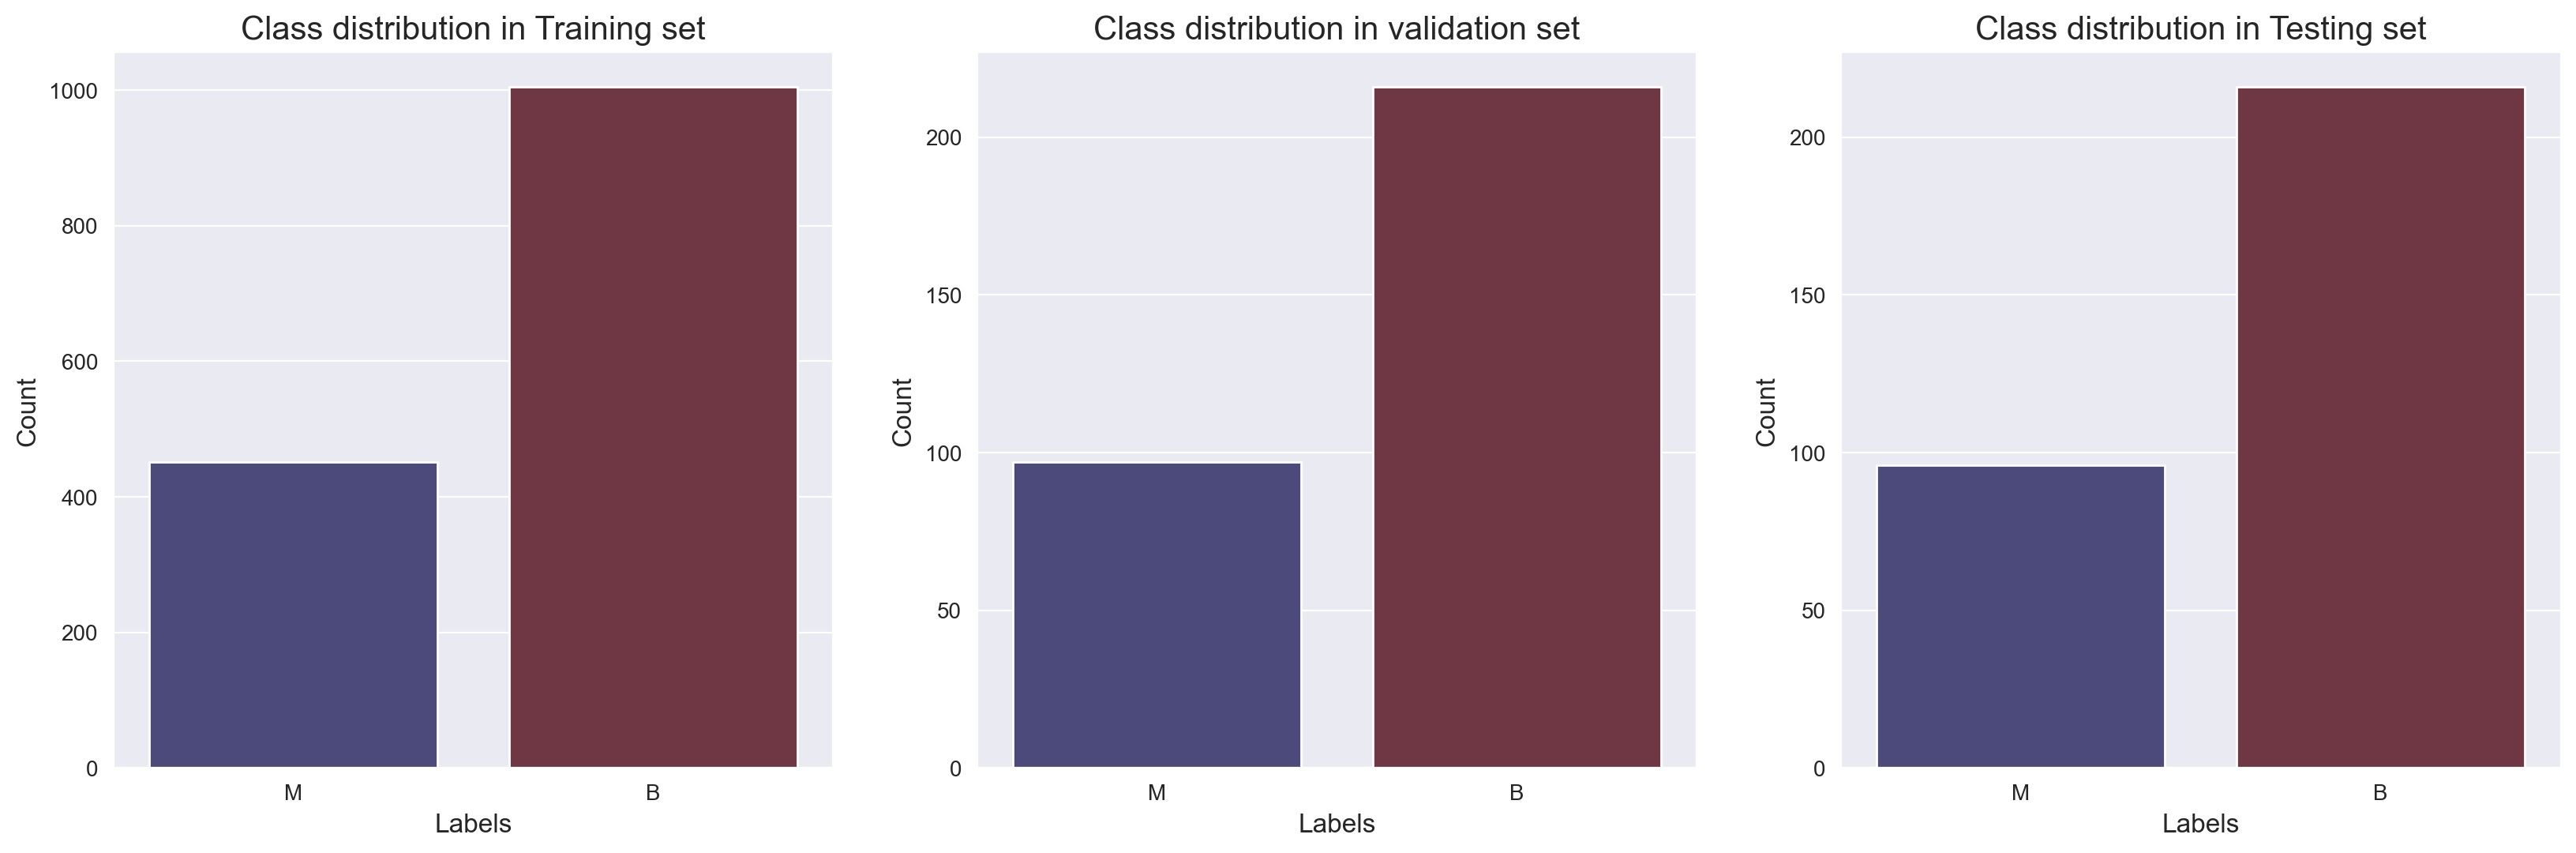

In [42]:
labels = ['M','B']

label1,count1 = np.unique(X_train.Label,return_counts=True)
label2,count2 = np.unique(X_val.Label,return_counts=True)
label3,count3 = np.unique(X_test.Label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])


plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire').set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire').set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire').set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

Implement at least three Deep Learning based classifiers: One needs to be a CNN, one can be a shallow neural network, e.g. a fully connected NN with one hidden layer.